# Implementation of L-layer neural network used to classify cat images

TODO: add data source 

# Load data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from collections import deque
from functions import *
%matplotlib inline

with h5py.File("data/train_catvnoncat.h5", "r") as f:
    train_set_x_orig = f["train_set_x"][()]
    train_set_y = f["train_set_y"][()]

with h5py.File("data/test_catvnoncat.h5", "r") as f:
    test_set_x_orig = f["test_set_x"][()]
    test_set_y = f["test_set_y"][()]

In [2]:
print(f"{train_set_x_orig.shape = }")
print(f"{train_set_y.shape = }")
print(f"{test_set_x_orig.shape = }")
print(f"{test_set_y.shape = }")

train_set_x_orig.shape = (209, 64, 64, 3)
train_set_y.shape = (209,)
test_set_x_orig.shape = (50, 64, 64, 3)
test_set_y.shape = (50,)


y = 0


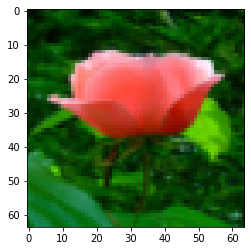

In [3]:
index = 3
plt.imshow(train_set_x_orig[index])
print(f"y = {train_set_y[index]}")

## Preprocess x datasets

After preprocessing data shoud be organised into four 2-dimensional arrays:
    
- `train_set_x`: (12288, 209),
- `test_set_x`: (12288, 50),
- `train_set_y`: (1, 209),
- `test_set_y`: (1, 50),

where each value in x is between 0 and 1 and each in y is either 0 or 1.

In [4]:
nx = train_set_x_orig.shape[0]
train_set_x = train_set_x_orig.reshape((nx,-1)).T # examples are columns
nx = test_set_x_orig.shape[0]
test_set_x = test_set_x_orig.reshape((nx,-1)).T
print(f"{train_set_x.shape = }")
print(f"{test_set_x.shape = }")

train_set_x.shape = (12288, 209)
test_set_x.shape = (12288, 50)


In [5]:
train_set_x = train_set_x/255
test_set_x = test_set_x/255

In [6]:
train_set_y = train_set_y.reshape(1,-1)
test_set_y = test_set_y.reshape(1,-1)

In [7]:
print(f"{train_set_y.shape = }")
print(f"{test_set_y.shape = }")

train_set_y.shape = (1, 209)
test_set_y.shape = (1, 50)


# Build model

Model has L hidden layers (customizable sizes) and uses ReLu activation function for all of them and then sigmoid for output layer.

In [8]:
def initialize_parameters(layer_sizes: list, seed: int = 0) -> dict:
    """Returns dictionary containing weights W1, ... WL and biases b1, ... bL of L-layer neural network.
    Args:
        layers_sizes: list containing number of units in each layer [n0, ... nL]
        seed: number passed to np.random.seed before initialization of parameters
    """
    np.random.seed(seed)
    parameters = dict()
    for i in range(1,len(layer_sizes)):
        # W[l] has size n[l] x n[l-1] where n[0], ..., n[l] are sizes of layers starting from input layer X
        parameters[f"W{i}"] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * 0.01
        parameters[f"b{i}"] = np.zeros((layer_sizes[i],1))
    return parameters

In [18]:
def forward_prop(X: np.ndarray, parameters: dict[str, np.ndarray], activations: list) -> dict[str,np.ndarray]:
    """Returns dict containing computed values of A1, ... AL and Z1, ... ZL given current parameters and the data.
    
    Note: lists has L+1 elements and the first element (i=0) is a dummy element used to allow for use of the same indices
    corresponding to layers 1, ... L as in python list (0), 1, ... L.
    
    Args:
        X: array of size (nx, m) with training data
        parameters: dict containing keys W1, ..., WL, b1, ... bL for model's parameters
        activations: list with functions used as activation for each layer
    """
    if len(activations) != len(layer_sizes):
        raise ValueError(f"{len(layer_sizes) = } != {len(activations)}, they should be equal!")
    
    A_lst = [X]
    Z_lst = [np.nan] # dummy
    for i in range(1,len(activations)):
        Wi = parameters[f"W{i}"]
        bi = parameters[f"b{i}"]
        Zi = Wi @ A_lst[i-1] + bi
        Ai = activations[i](Zi)
        Z_lst.append(Zi)
        A_lst.append(Ai)
    return {"A_lst": A_lst, "Z_lst": Z_lst}

In [19]:
# check if it works properly
m = 10
X = train_set_x[:,:m]
Y = train_set_y[:,:m]
layer_sizes = [X.shape[0], 5, 3, 2, Y.shape[0]]
params = initialize_parameters(layer_sizes)
L = len(layer_sizes) - 1
activations = [*[relu]*L, sigmoid]
forward_results = forward_prop(X, params, activations)
AL = forward_results["A_lst"][-1]
assert Y.shape == AL.shape
assert Y.shape[1] == m
print(Y.shape, AL.shape)
cost = cross_entropy(AL, Y)
print(f"Initial cost: {cost}")
print(f"{cost.shape = }")
print(f"Model has {L} hidden layers.")

(1, 10) (1, 10)
Initial cost: 0.6931473482220166
cost.shape = ()
Model has 4 hidden layers.


In [20]:
def init_dA(Y: np.ndarray, A:np.ndarray) -> np.ndarray:
    """Computes the derivative of cross-entropy cost function with respect to A (output of last layer of the  model)."""
    if Y.shape != A.shape: 
        raise ValueError(f"{Y.shape = } and {A.shape = }, they should be equal.")
    dA = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    assert dA.shape == A.shape
    return dA

init_dA(Y, AL)

array([[ 2.00000053,  2.00000045, -1.99999894,  2.00000117,  2.00000066,
         2.00000033,  2.00000073, -1.99999918,  2.00000094,  2.00000043]])

In [29]:
def backward_prop(
    Y: np.ndarray, parameters: dict, activations: list, activations_derivatives: list,
    A_lst: list[np.ndarray], Z_lst: list[np.ndarray], init_dA
) -> dict[str, np.ndarray]:
    """Implementation of backpropagation part of nn. Returns dict containing derivatives of parameters.
    
    Args:
        Y: array of size (1,m) with response variable 
        parameters: dict containing weights W1, ... WL and biases b1, ... bL
        activations: list of L+1 activation functions, where the last element is activation of output layer
        activations_derivatives: list of L+1 functions used to compute derivatives of activation functions
        A_lst: list of cached A values computed during forward propagation
        Z_lst: list of cached Z values computed during forward propagation
        init_dA: function used to initialize recurssion (derivative of cost with respect to last activation layer AL)
    """
    m = Y.shape[1]
    L = len(activations)-1
    print(f"Running backpropagation for {L} layers:")
    # TODO Change lists to deque?
    # Note: There are L+1 elements because i = 0 is dummy element that allows for use of the same indices
    # corresponding to layers 1 ... L as in python list (0,) 1, ... L.
    dA_lst = [np.nan]*(L+1)
    dZ_lst = [np.nan]*(L+1)
    dW_lst = [np.nan]*(L+1)
    db_lst= [np.nan]*(L+1)
    AL = A_lst[-1]
    assert np.array_equal(AL, A_lst[L]) # This is here to emphasise the difference in numbering
    dA_lst[-1] = init_dA(Y,AL)
    for s in range(L):
        # Compute values in i-th layer for i = L, L-1, ... 1
        i = L-s
        print(f"Computing gradients in L{i}...")
        dAi = dA_lst[i]
        Zi = Z_lst[i]
        dZi = dAi * activations_derivatives[i](Zi)
        Wi = parameters[f"W{i}"]
        dWi = (1/m)*(dZi @ A_lst[i-1].T)
        dbi = (1/m)*np.sum(dZi, axis = 1, keepdims=True)
        dAi_minus_1 = Wi.T @ dZi
        # Assert shapes
        assert dZi.shape == Zi.shape
        assert dWi.shape == Wi.shape
        assert dbi.shape == parameters[f"b{i}"].shape
        assert dAi_minus_1.shape == A_lst[i-1].shape
        # Append computed values to relevant lists
        dZ_lst[i] = dZi
        dW_lst[i] = dWi
        db_lst[i] = dbi
        dA_lst[i-1] = dAi_minus_1

    # There should be as many gradients as hidden layers.
    assert len(db_lst) == L+1
    assert len(dW_lst) == L+1
    assert np.isnan(db_lst[0])
    assert np.isnan(dW_lst[0]) # check dummies
    # Combine lists into dictionary of gradients.
    grads = {}
    for i in range(1,L+1):
        grads[f"dW{i}"] = dW_lst[i]
        grads[f"db{i}"] = db_lst[i]
    assert len(parameters) == len(grads)
    return grads

In [30]:
activations_derivatives = activations = [*[relu_derivative]*L, sigmoid_derivative] 

# TODO would be nice if instead of passing activations and derivatives separately, there would be abstract Function class implementing
# both function and its derivative, so that one can pass just Function instance and make sure they match; same with cost function and init_dA.

# print(activations)
# print(activations_derivatives)

A_lst = forward_results["A_lst"]
Z_lst = forward_results["Z_lst"]

backward_results = backward_prop(Y, params, activations, activations_derivatives,A_lst, Z_lst, init_dA)

Running backpropagation for 4 layers:
Computing gradients in L4...
Computing gradients in L3...
Computing gradients in L2...
Computing gradients in L1...


In [31]:
backward_results.keys()

dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3', 'dW4', 'db4'])

In [32]:
def update_parameters(parameters: dict[str,np.ndarray], gradients:dict[str,np.ndarray], learning_rate: float):
    """Return updated parameters so that for each var = var - `learning_rate` * dvar.
    
    Implements basic version of gradient descent.
    Args:
        parameters: ...
        gradients: ...
        learning_rate: ...
    """
    new_parameters = dict()
    for var, value in parameters.items():
        dvar = gradients[f"d{var}"]
        assert dvar.shape == value.shape # arrays should have the same size as their gradients 
        new_parameters[var] = value - learning_rate * dvar
    return new_parameters